In [1]:
#libraries for plotting in an external window
# pip install PyQt5
# pip install PyQt6
# pip install PySide6
# pip install PySide2

In [2]:
pip install rpy2 

Note: you may need to restart the kernel to use updated packages.


In [1]:
# The usual suspects
import pandas as pd
import random
import math
import torch
import time
# Make sure torch.__version__>1.10

# Homemade librairies
from volume_interest import *
from tracking import *
from plots import *

# Classes tutorial

We create several classes to make the implementation of the algorithm easier. In this tutorial we will go through 3 of them:

- `volume_interest.py`
- `plots.py`
- `tracking.py`

## 1 - volume_interest.py

The **EM algorithm** implementation relies on a **voxelized volume of interest (VOI)**. As its name indicates, the `VolumeOfInterest` class is responsible for the modeling of the volume of interest and its voxelization. 

### Instanciation

When declaring an **instance** of `VolumeOfInterest`, one must provide **3 parameters**:

- `low_high_edges`: `([x_low,y_low,z_low], [x_high,y_high,z_high])` in m, representing repectivly the **bottom** and **upper** corner **of the VOI**.


- `n_vox_xyz`: `Tuple[int] = [Nx,Ny,Nz]` respectively the **number of voxels** along the x,y and z direction.


- `voxel_width`: `float` the **size of a voxel** in m. **Make sure that `(i_high - i_low)/voxel_width = Ni` !!**

If these parameters are not provided, default parameters corresponding to standard TomOpt VOI will be used. In case one wants a custom VOI, the `VolumeOfInterest` should be instancieted as follow:

In [2]:
# Default VOI instanciation
voi = VolumeOfInterest()

# Custom VOI instanciation
xyz_min = [0, 0, 0.2] # in meters
xyz_max = [1, 1, 0.8] # in meters
n_vox_xyz = (10,10,6) 
voxel_width = 0.1 # in meters

voi = VolumeOfInterest(low_high_edges = (xyz_min,xyz_max), 
                       n_vox_xyz = n_vox_xyz,
                       voxel_width = voxel_width)

### Features

The `generate_voxels()` method will **generate a grid of voxels** based on the input parameters provided above, using the `compute_voxel_centers`. Features of the voxelized volume are:

 - `voxel_centers`: `torch.tensor()` with size `(Nx,Ny,Nz,3)`. It contains the $x,y,z$ position of the center of each voxel. The position of the center of the voxel with indices $ix,iy,iz$ is `voxel_centers[ix,iy,iz]`.
 
 
 
 - `voxel_edges`: `torch.tensor()` with size `(Nx,Ny,Nz,2,3)`. It contains the $x,y,z$ position of the lower left and upper righ corner of each voxel. The positions of the lower left and upper right corner of the voxel with indices $ix,iy,iz$ are respectively `voxel_centers[ix,iy,iz,0,:]` and `voxel_centers[ix,iy,iz,1,:]`. 
 
 

In [3]:
ix,iy,iz = 0,0,0

# Voxel centers
print('Voxel with indices {},{},{} is located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_centers[ix,iy,iz].numpy()))

# Voxel edges
print('\nLower left corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,0].numpy()))
print('\nUpper right corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,1].numpy()))

Voxel with indices 0,0,0 is located at x,y,z = [0.05 0.05 0.75]

Lower left corner of voxel with indices 0,0,0 
is located at x,y,z = [0.  0.  0.7]

Upper right corner of voxel with indices 0,0,0 
is located at x,y,z = [0.1 0.1 0.8]


Now that the VOI is properly defined, we can have a look at it using the `plot_muon_track()` method (in `plot.py`). This method is designed to plot both the VOI and a given track but if `track` is none it only plots the VOI.

## 2 - tracking.py 

The EM algorithm will require the position of a muon every time it enters and exits a voxel. The **`Tracking` class** will handle all the **computations** related to the **tracks** and the **voxel triggering**.

### Instantiation

 - `voi`: An instance of the `VolumeOfInterest` class.
 
 - `data`: `pandas.DataFrame`
 
 - `em_iter`: an integer representing the number of iterations for the expectation-maximization (EM) algorithm
 
The dataset we use contains the following features: 

In [4]:
data_pb = pd.read_csv('../../../TomOpt_Data_EM_Analysis/lead.csv')
print('Features:')
print(data_pb.columns)
print(data_pb.shape)

Features:
Index(['Unnamed: 0', 'mom', 'xyz_in_x', 'xyz_in_y', 'xyz_in_z', 'xyz_out_x',
       'xyz_out_y', 'xyz_out_z', 'theta_in_x', 'theta_in_y', 'theta_out_x',
       'theta_out_y', 'hits_above_gen_panel0_x', 'hits_above_gen_panel0_y',
       'hits_above_gen_panel0_z', 'hits_above_gen_panel1_x',
       'hits_above_gen_panel1_y', 'hits_above_gen_panel1_z',
       'hits_above_gen_panel2_x', 'hits_above_gen_panel2_y',
       'hits_above_gen_panel2_z', 'hits_above_gen_panel3_x',
       'hits_above_gen_panel3_y', 'hits_above_gen_panel3_z',
       'hits_below_gen_panel4_x', 'hits_below_gen_panel4_y',
       'hits_below_gen_panel4_z', 'hits_below_gen_panel5_x',
       'hits_below_gen_panel5_y', 'hits_below_gen_panel5_z',
       'hits_below_gen_panel6_x', 'hits_below_gen_panel6_y',
       'hits_below_gen_panel6_z', 'hits_below_gen_panel7_x',
       'hits_below_gen_panel7_y', 'hits_below_gen_panel7_z'],
      dtype='object')
(45287, 36)


In [5]:
start = time.time()
data_pb=data_pb[0:30000]
myTracks1=Tracking(voi,data_pb,15)
end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material using",len(data_pb),"events:",run_time," minutes")

Running time for prediction of VOI material using 30000 events: 8.1  minutes


### Features

- `tracks`: `torch.tensor` with size `[3,VOI.n_vox_xyz[2]+1,Nevent]`. It contains the muon position ($x,y,z$) when entering/exiting a layer of voxel along z. Computed by the `compute_discrete_tracks()` method.

- `triggered_voxels`: `list` with length `Nevent`. Each element of the list is a `torch.tensor` with size `[N,3]` where `N` is the number of triggered voxels of the given event.

- `rad_len`: A `torch.tensor` with shape `(n_iter, N, N, N1)`. It represents the final reconstructed image for every iteration.

- `scatter_density`: A `torch.tensor` with shape `(n_iter, N, N, N1)`. It represents the scatter density of the object being reconstructed.

In [6]:
# tracks
layer = 0
event = 0
print('\nMuon #{} enters voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks1.tracks[0,layer,myTracks1.indices[event]].numpy(),
                                                                 myTracks1.tracks[1,layer,myTracks1.indices[event]].numpy(),
                                                                 myTracks1.tracks[2,layer,myTracks1.indices[event]].numpy()))
print('\nMuon #{} exits voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks1.tracks[0,layer+1,myTracks1.indices[event]].numpy(),
                                                                 myTracks1.tracks[1,layer+1,myTracks1.indices[event]].numpy(),
                                                                 myTracks1.tracks[2,layer+1,myTracks1.indices[event]].numpy()))

# triggered_voxels
print('\nMuon #{} triggers voxels with indices:\n {}'.format(event, myTracks1.triggered_voxels[event]))


Muon #0 enters voxel layer 0 at x,y,z = 0.4267718761557134,-0.15551504769870605,0.800000011920929

Muon #0 exits voxel layer 0 at x,y,z = 0.4525704493222377,-0.10384990135731102,0.699999988079071

Muon #0 triggers voxels with indices:
 [[5, 0, 3], [5, 0, 4], [5, 1, 4], [5, 1, 5]]


# Full Pb - Plotting Estimated Radiation Length

We can know plot above's features using the `plot_muon_track()`, `plot_discrete_track_2d()` and `plot_discrete_track_3d()` functions from plot.py.

The plots.py file contains functions for visualizing the muon trajectory and triggered voxels inside the volume of interest (VOI) in 2- and 3-dimensional orientations.

### Functions

 - `plot_muon_track`: Plots only the muon trjectory within the VOI.
 
 - `plot_discrete_track_2d`: 2D visualization of muon trajectories and triggered voxels within the VOI.
 
 - `plot_discrete_track_3d`: 3D visualization of muon trajectories and triggered voxels within the VOI.
 
    These 3 functions have the same following input parameters
      - `VOI`: instance of the VolumeOfInterest class
      - `tracking`: instance of the Tracking class
      - `event`: event number
 
 - `plot_event_Lrad_heatmaps`: Heatmaps of radiation length for every layer in a VOI.
 
    This function takes the following 4 inputs:
      - `L_rad`:  3D tensor with shape (10, 10, 6), representing the radiation length values for each voxel in the detector.
      - `event`: int denoting the event number.
      - `log_scale`: Boolean with a default value of False for specifying the use of Log scale while plotting.
      - `org_Lrad`: Boolean with a default value of False for indicating that th eradiation length to be plottted is the VOI' original known radiation length.

 - `plot_rad_len_across_iter`:
     This function takes the following 3 inputs:
      - `em_iter`: int denoting the event number.
      - `rad_len`:  4D tensor with shape (n_events, 10, 10, 6), representing the radiation length values for each voxel in the VOI for all events happening in the detector.
      - `org_rad_len`: Original radiation length of the VOI.

 - `plot_muon_hits_count`:
     This function takes as an input:
      - `hits`: a torch tensor of shape (N, N, N1), containing the number of muons that pass through each voxel.

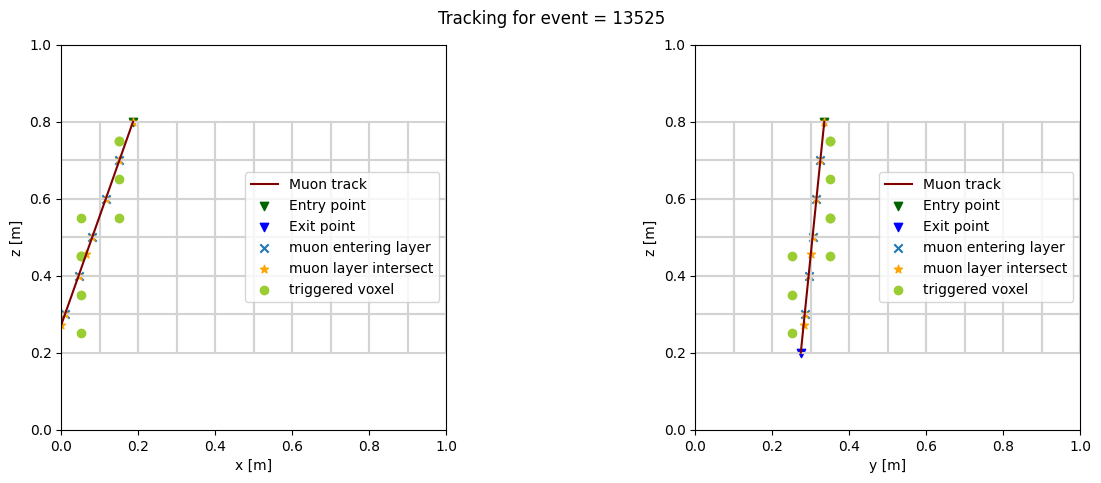

In [7]:
event=random.randint(0,len(myTracks1.triggered_voxels))
%matplotlib inline
plot_discrete_track_2d(VOI=voi, tracking=myTracks1, event = event)

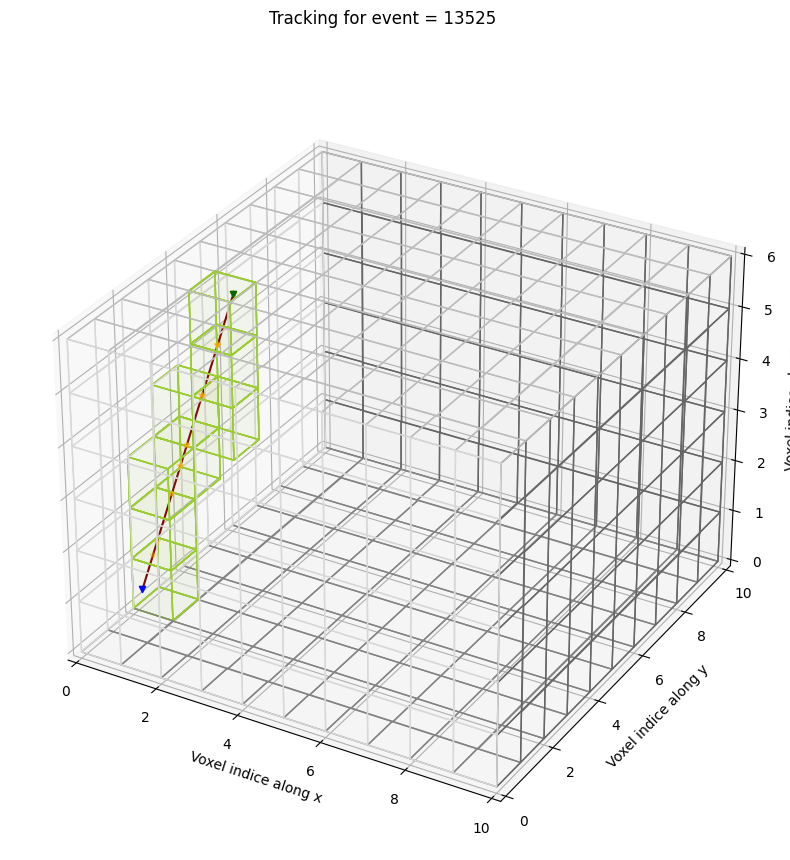

In [8]:
%matplotlib inline
plot_discrete_track_3d(VOI=voi, tracking=myTracks1, event = event)

In [9]:
import pickle
Lrad_pb=torch.load('../../../TomOpt_Data_EM_Analysis/lead.pt')
L_rad_org_pb=np.transpose(Lrad_pb, (1, 2, 0))

with open('materials_radiation_length.pkl', 'rb') as f:
    matr_lrad_dict = pickle.load(f)
    
unique_lrad=torch.unique(L_rad_org_pb)
mat_names=""
for m in unique_lrad:
    mat_names=mat_names+matr_lrad_dict[round(float(m),4)]+"("+str(round(float(m),4)) +")" 
    mat_names=mat_names+" "
print("Material includes: ",mat_names)

lrad_distrb_pb=radiation_distribution(myTracks1.rad_length,L_rad_org_pb,15) 

Material includes:  Pb(0.0056) 


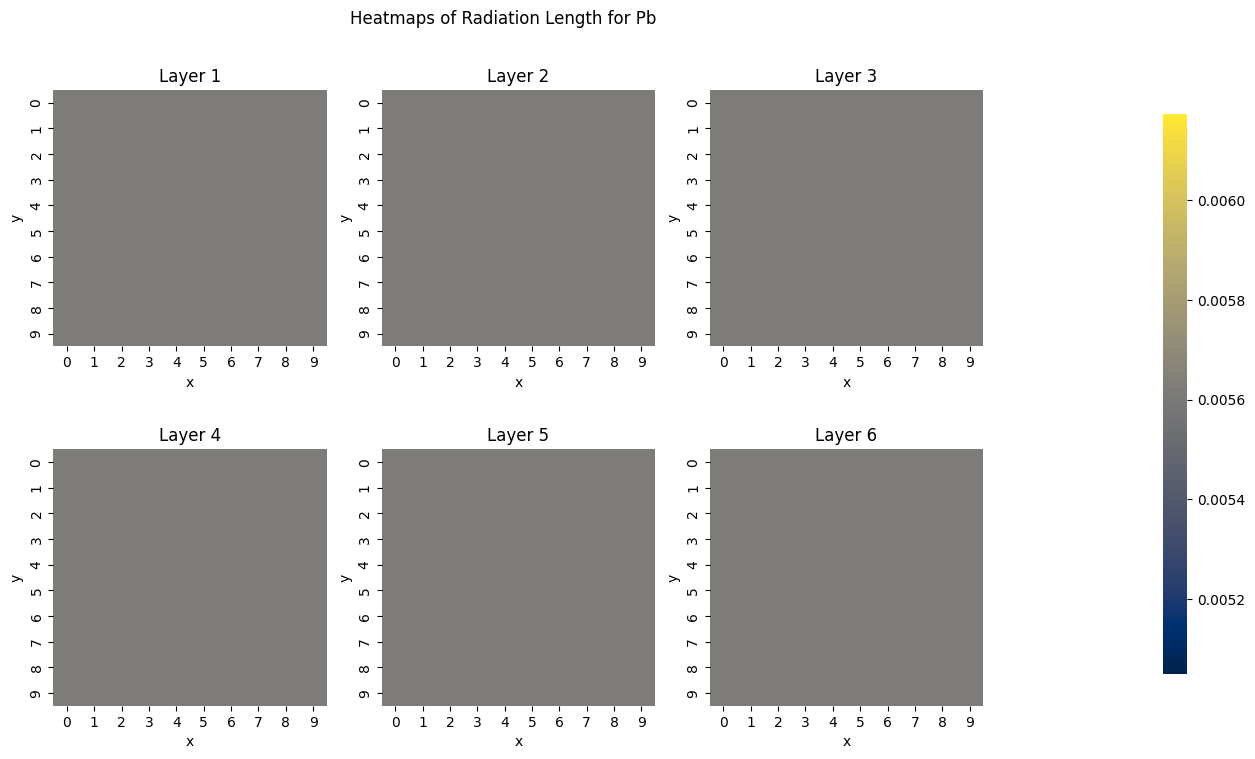

In [10]:
plot_event_Lrad_heatmaps(L_rad_org_pb,0,False,True)

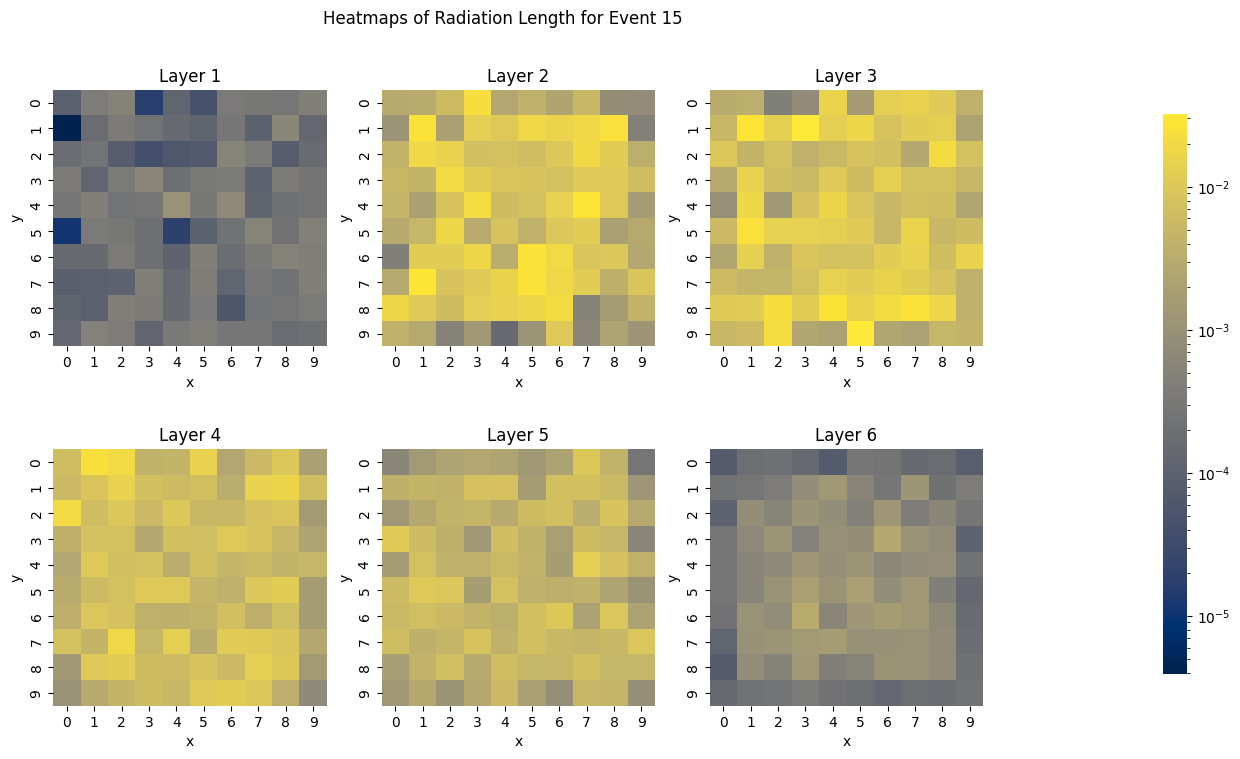

In [11]:
plot_event_Lrad_heatmaps(myTracks1.rad_length[myTracks1.em_iter-1],myTracks1.em_iter-1, True, False)

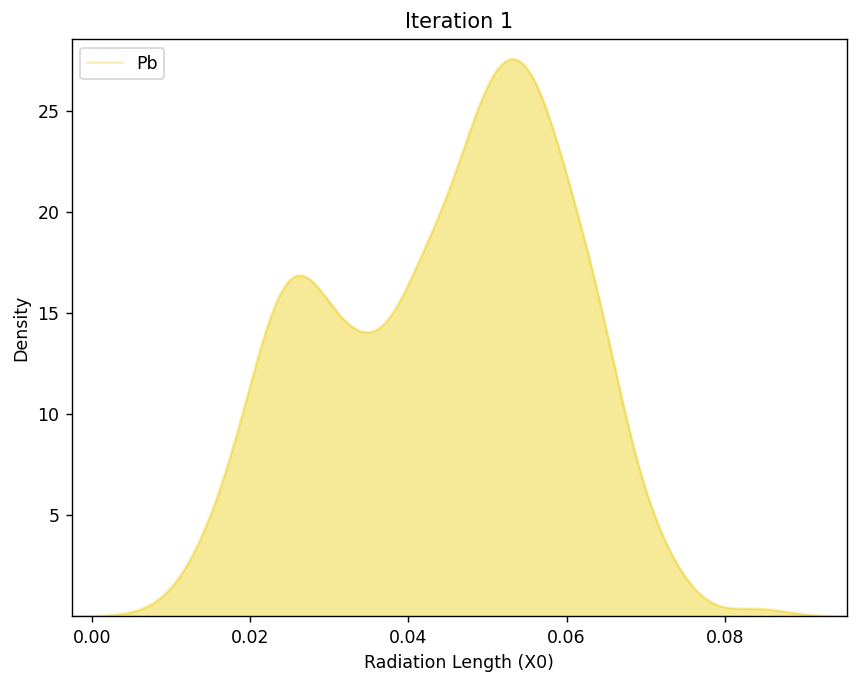

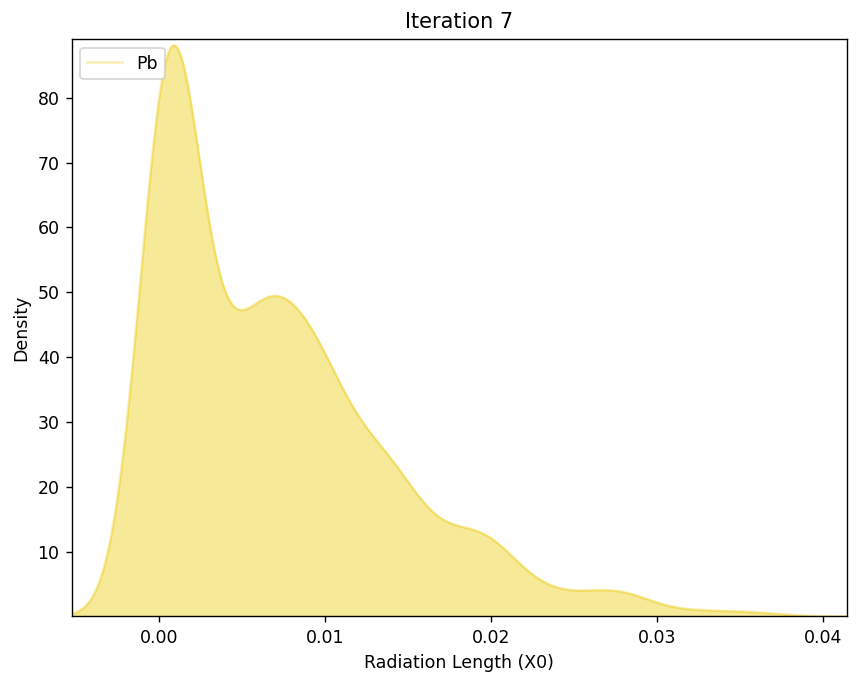

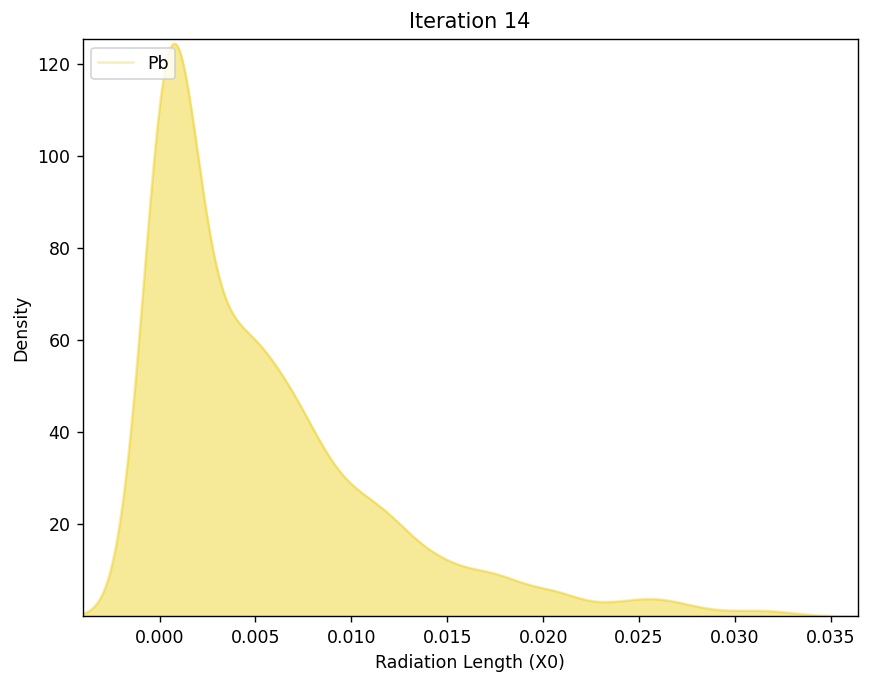

In [12]:
matr_lrad_pb, x_lim_pb, y_lim_pb = compute_density(lrad_distrb_pb,myTracks1.em_iter,False)
rand_colors=generate_distinct_hex_colors(len(matr_lrad_pb))
plot_density_for_LRad(matr_lrad_pb, x_lim_pb, y_lim_pb,1,rand_colors,False)
plot_density_for_LRad(matr_lrad_pb, x_lim_pb, y_lim_pb,int(myTracks1.em_iter/2),rand_colors,False)
plot_density_for_LRad(matr_lrad_pb, x_lim_pb, y_lim_pb,myTracks1.em_iter-1,rand_colors,False)

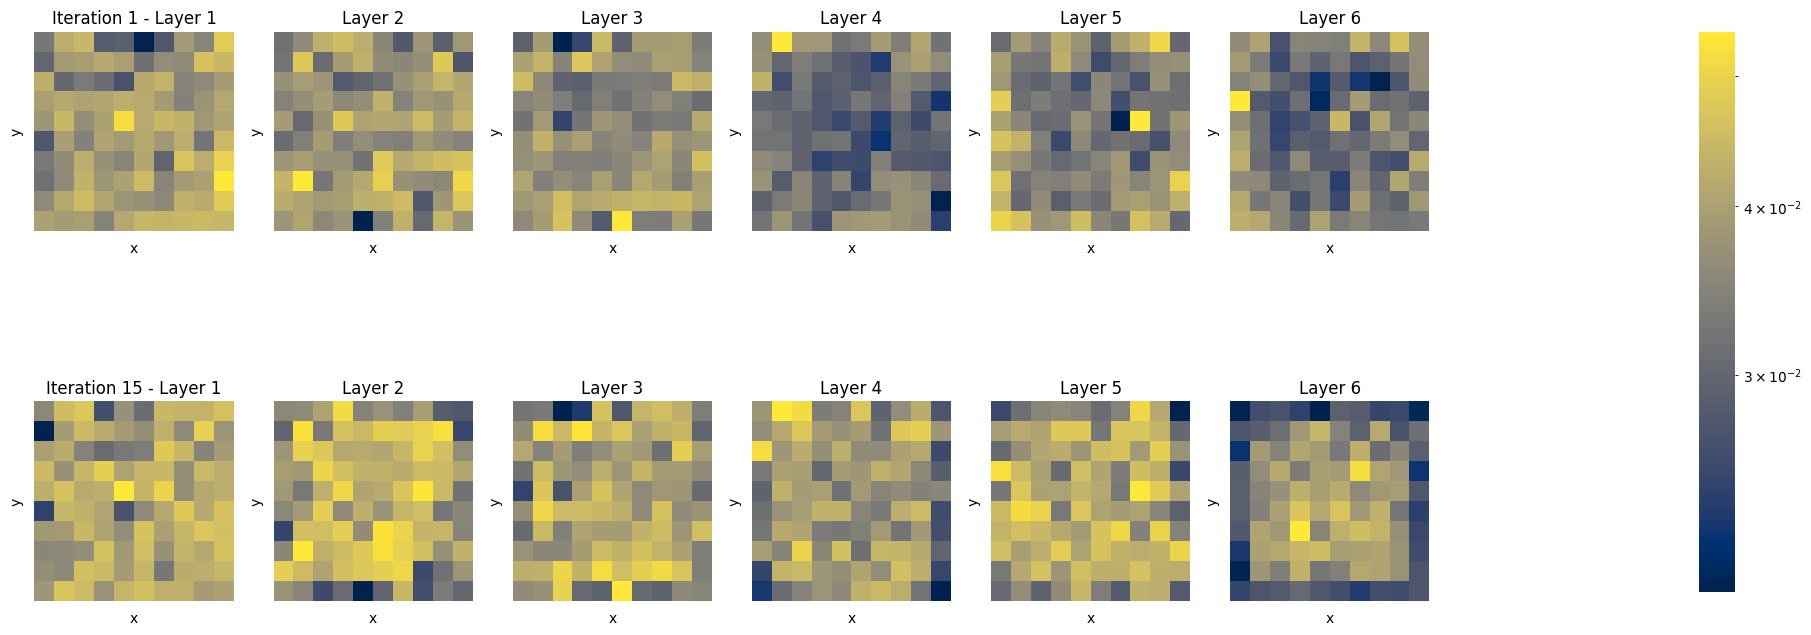

In [13]:
plot_rad_len_across_iter(15,myTracks1.rad_length,L_rad_org_pb)

# Composite VOI: U, Pb, Fe, Al, Air - TomOpt Data

In [35]:
data2 = pd.read_csv('../../../TomOpt_Data/Hits_100k_events_cubes_TomOpt.csv')
print("Shape of data: ",data2.shape)
Lrad_composite_mtr=torch.load('../../../TomOpt_Data/rad_length_cubes.pt')
L_rad_org_composite_mtr=np.transpose(Lrad_composite_mtr, (1, 2, 0))

Shape of data:  (29853, 36)


In [36]:
start = time.time()
myTracks2=Tracking(voi,data2,15)
end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material: ",run_time,"minutes")

unique_lrad=torch.unique(L_rad_org_composite_mtr)
mat_names=""
for m in unique_lrad:
    mat_names=mat_names+matr_lrad_dict[round(float(m),4)]+"("+str(round(float(m),4)) +")" 
    mat_names=mat_names+" "
print("Material includes: ",mat_names)

lrad_distrb_composite_mtr=radiation_distribution(myTracks2.rad_length,L_rad_org_composite_mtr,myTracks2.em_iter) 

Running time for prediction of VOI material:  5.0 minutes
Material includes:  U(0.0031) Pb(0.0056) Fe(0.0176) Al(0.089) Air(303.9) 


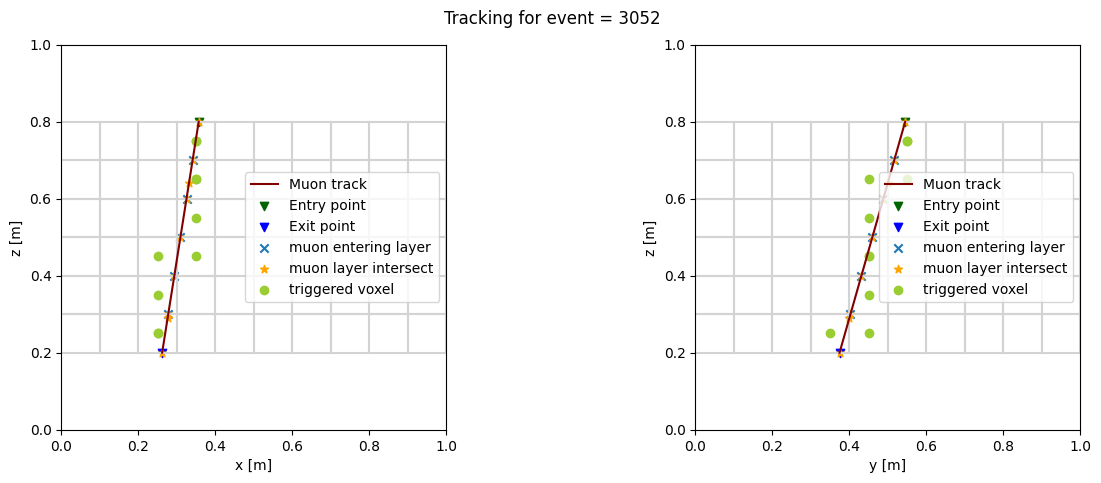

In [37]:
event=random.randint(0,len(myTracks2.triggered_voxels))
%matplotlib inline
plot_discrete_track_2d(VOI=voi, tracking=myTracks2, event = event)

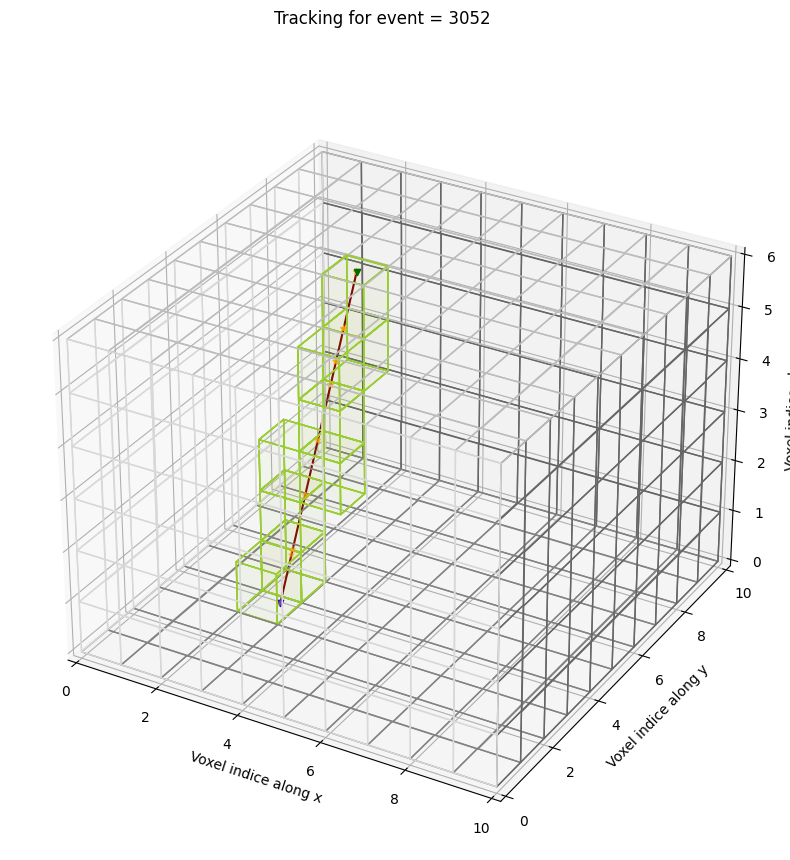

In [38]:
%matplotlib inline
plot_discrete_track_3d(VOI=voi, tracking=myTracks2, event = event)

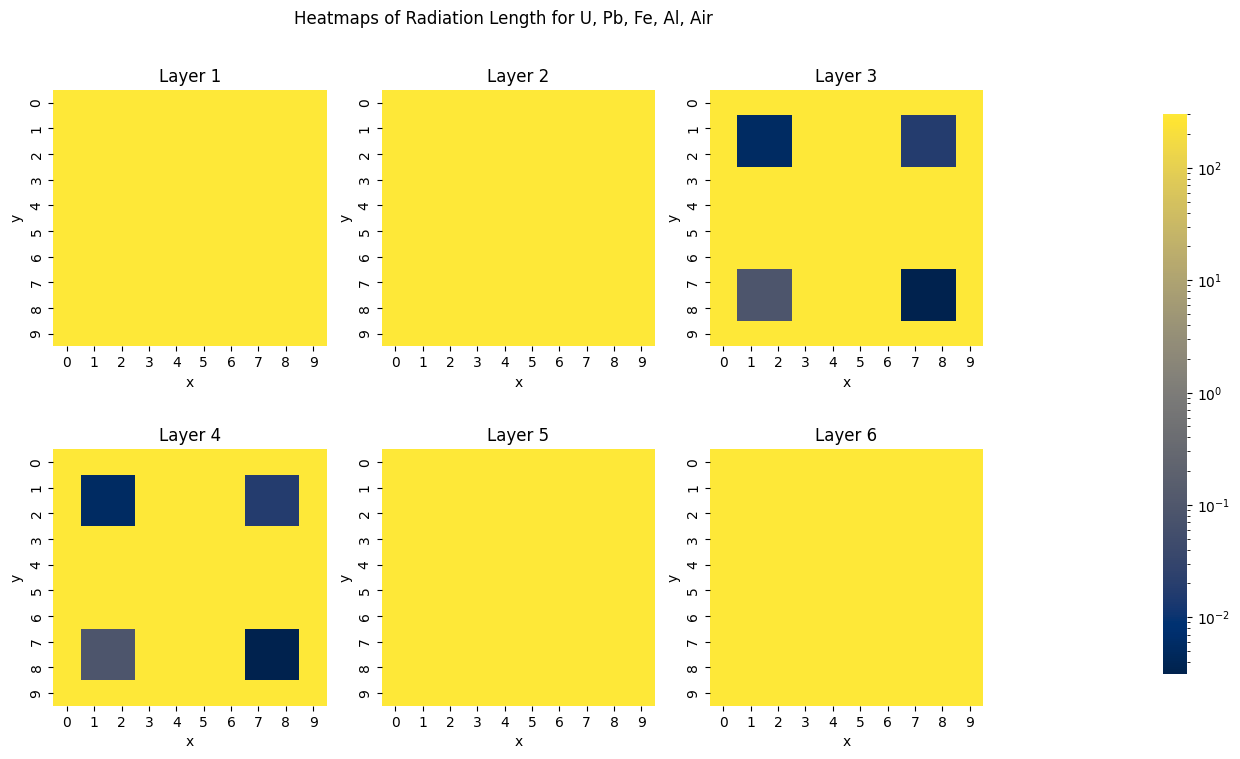

In [39]:
plot_event_Lrad_heatmaps(L_rad_org_composite_mtr,0,True,True)

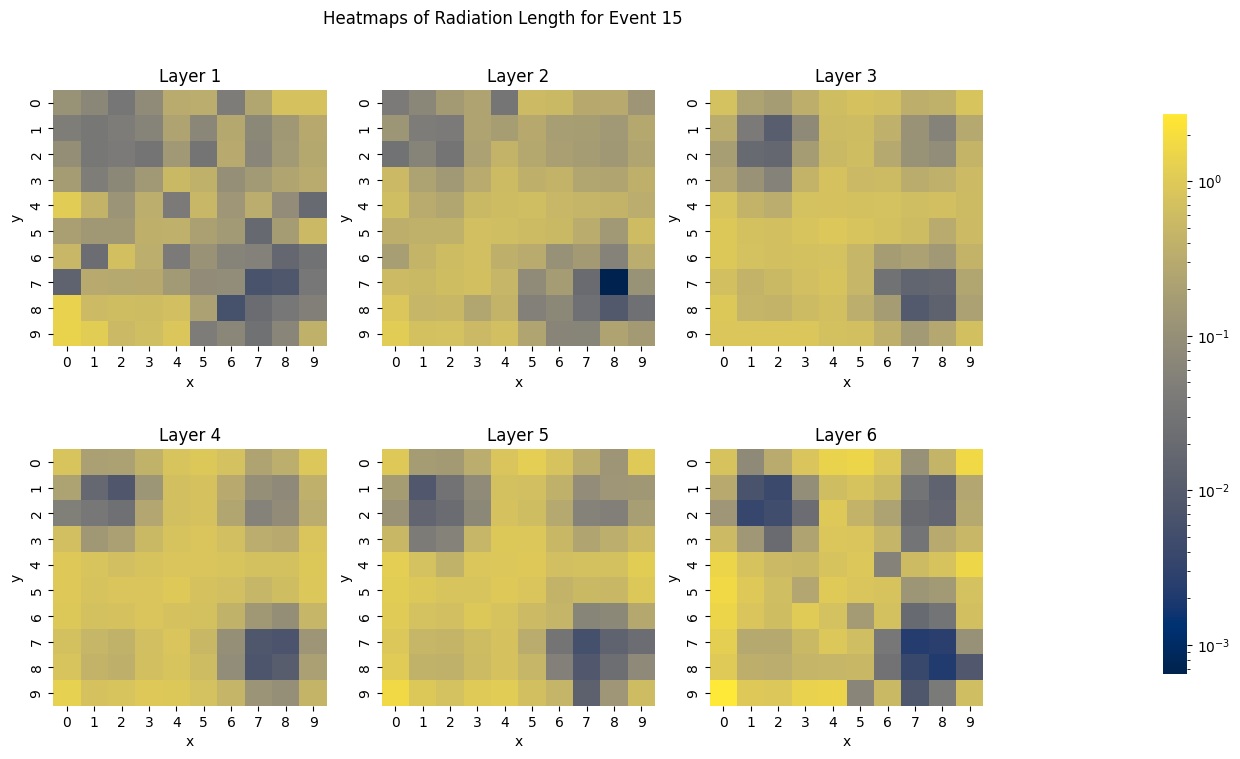

In [40]:
plot_event_Lrad_heatmaps(myTracks2.rad_length[myTracks2.em_iter-1],myTracks2.em_iter-1,True,False)

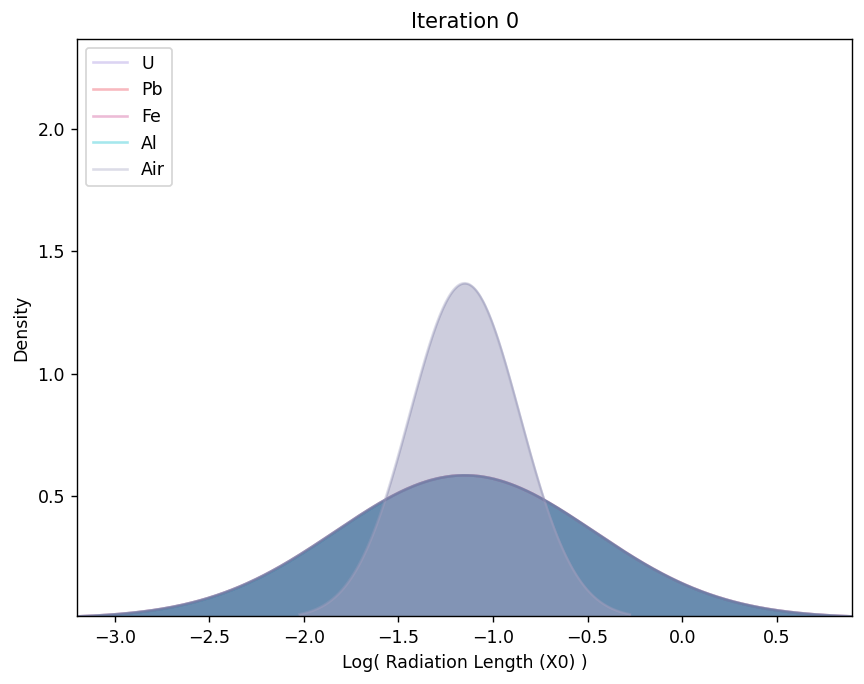

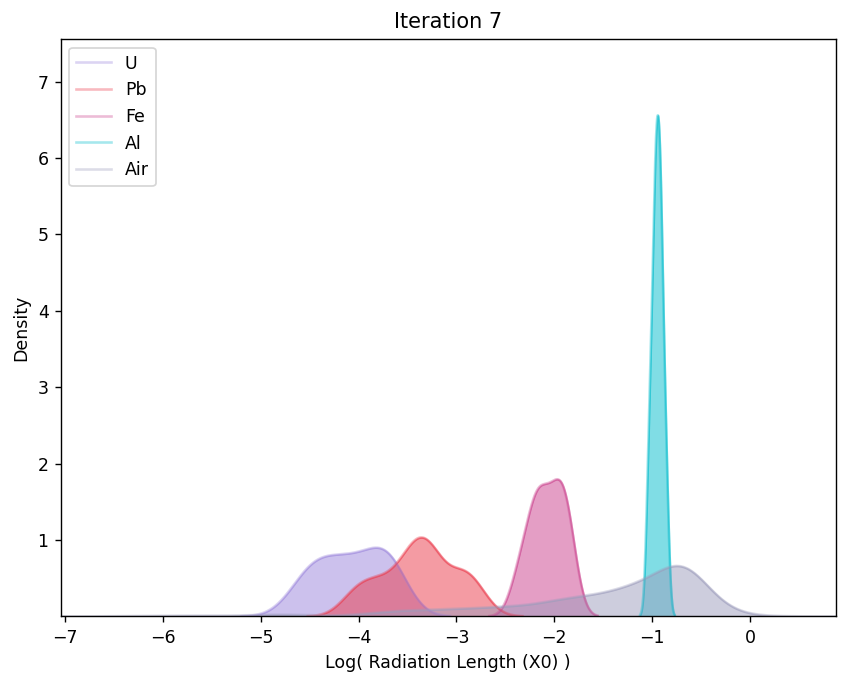

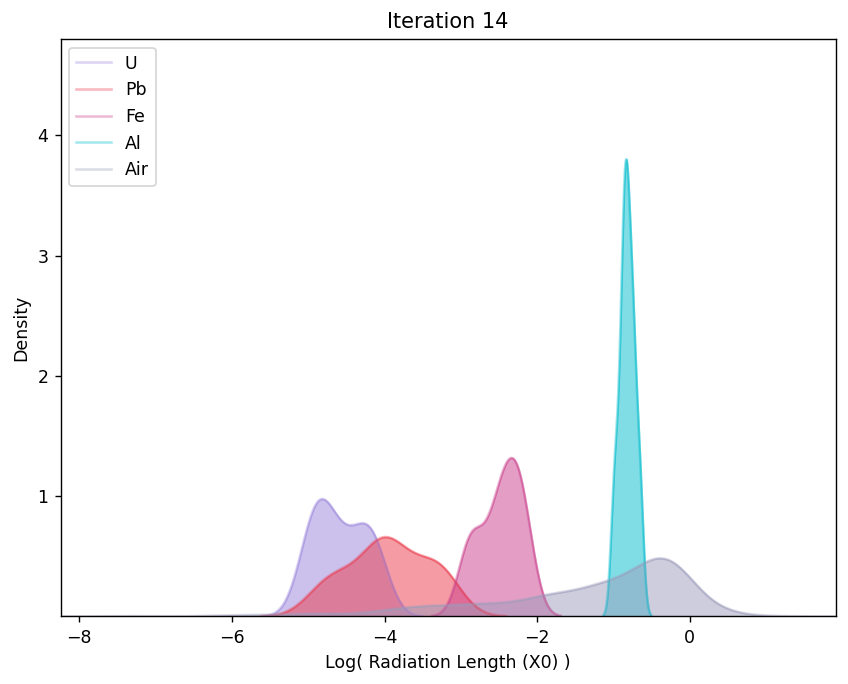

In [41]:
rand_colors=generate_distinct_hex_colors(len(L_rad_org_composite_mtr))
matr_lrad2, x_lim2, y_lim2 = compute_density(lrad_distrb_composite_mtr,myTracks2.em_iter,True)
plot_density_for_LRad(matr_lrad2, x_lim2, y_lim2,0,rand_colors,True)
plot_density_for_LRad(matr_lrad2, x_lim2, y_lim2,int(myTracks2.em_iter/2),rand_colors,True)
plot_density_for_LRad(matr_lrad2, x_lim2, y_lim2,myTracks2.em_iter-1,rand_colors,True)

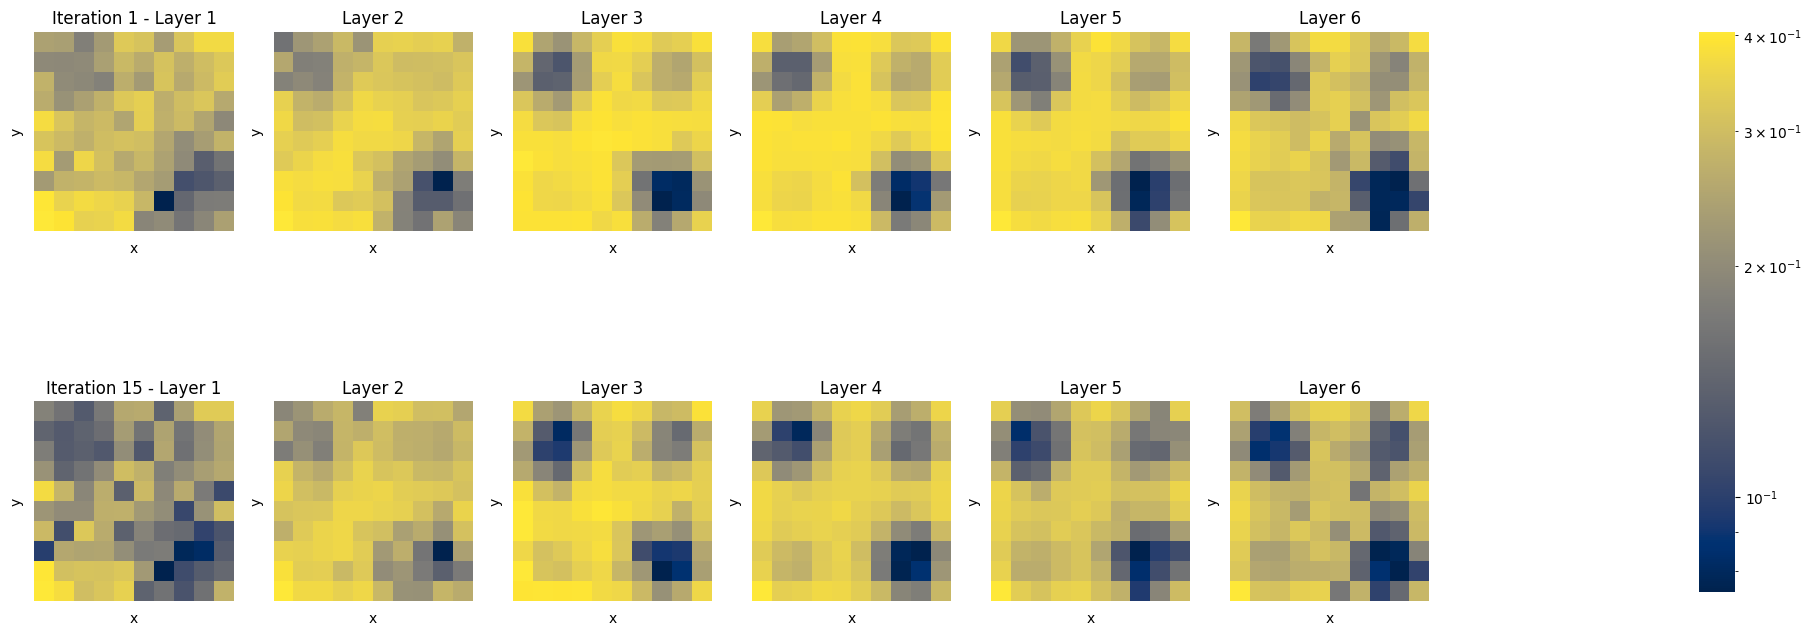

In [42]:
plot_rad_len_across_iter(myTracks2.em_iter,myTracks2.rad_length,L_rad_org_composite_mtr)